1. LSTM multiinput-series: https://www.aiproblog.com/index.php/2018/11/13/how-to-develop-lstm-models-for-time-series-forecasting/
2. LSTM train/test: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
3. Loss plotting: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
4. Overfit/Underfit: https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import LSTM
from keras.layers import Dense
import lightgbm as lgb
from scipy.stats import uniform, randint

In [2]:
def diagnostic_stats(ytrue, ypred):
    """
    https://stats.stackexchange.com/questions/142248/difference-between-r-square-and-rmse-in-linear-regression
    
    https://www.sciencedirect.com/topics/engineering/mean-bias-error
    """
    n = len(ytrue)

    # Check that the ytrue and ypred are equal length vector.
    assert n == len(ypred)
    
    # sum squared error
    sse = np.sum((ytrue - ypred)**2)
    
    # root mean square error
    rmse = np.sqrt(sse/n)

    # total sum of squares
    tss = np.sum((ytrue - np.mean(ytrue))**2)
    tst = np.sum((ypred - np.mean(ypred))**2)
    tstp = tst**0.5
    tssp = tss**0.5
    
    soorat = np.sum((ytrue-np.mean(ytrue))*(ypred-np.mean(ypred)))
    
    # Rsquare
    ##rsqr = 1 - sse/tss
    rsqr = (soorat/(tssp*tstp))**2

    # Mean biased error
    mbe = np.mean(ytrue - ypred)
    
    # IOAD
    num = np.sum((ytrue - ypred)**2)
    denom = np.abs(ytrue - ypred) + np.abs(ytrue + ypred)
    ioad = 1 - num/np.sum(denom**2)

    print("RMSE: %1.3f, R^2: %1.3f, MBE: %1.3f, IOAD: %1.3f"%(rmse, rsqr, mbe, ioad))
    
    return rmse, rsqr, mbe, ioad

In [3]:
df = pd.read_csv('rnn_data_prajwal.csv', 
                 parse_dates=['DateTime'], index_col='DateTime')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
df.head()

,Fc,Ta,Ws,Fg,VPD,Fn,q,Ts,Sws
DateTime,,,,,,,,,
2013-01-01 01:00:00,3.070399,26.998711,2.08,-20.984654,1.183521,-39.635899,0.014801,32.291790,0.032662
2013-01-01 01:30:00,2.948313,26.629910,2.47,-19.131921,1.067606,-35.979652,0.015045,32.036301,0.032636
2013-01-01 02:00:00,2.369790,26.294310,1.95,-18.278720,1.002275,-38.033844,0.015030,31.798710,0.032619
2013-01-01 02:30:00,0.105580,25.739479,1.55,-17.862080,0.927464,-41.878986,0.014810,31.572710,0.032582
2013-01-01 03:30:00,2.085828,24.548740,2.69,-21.647482,0.792163,-57.483334,0.014242,31.069750,0.032534


In [5]:
Xvar = ['Ta', 'Ws', 'Fg', 'VPD', 'Fn', 'q', 'Ts', 'Sws']
yvar = 'Fc'

### LSTM 

#### Data preparation

In [146]:
# split into input (X) and output (Y) variables
n_train= 8050

train_df = df.iloc[:n_train]
test_df = df.iloc[n_train:] 

print('Train:', train_df.shape, 'Test:', test_df.shape)

X_train, y_train = train_df[Xvar], train_df[yvar]
X_test, y_test = test_df[Xvar], test_df[yvar]

print('X_train:', X_train.shape, 'y_train:', y_train.shape)
print(X_train.keys())

scaler1 = StandardScaler()
X_train_scaled = scaler1.fit_transform(X_train)
scaler2 = StandardScaler()
y_train_scaled = scaler2.fit_transform(y_train.values.reshape(-1,1))
y_train_std, y_train_mean = np.std(y_train.values), np.mean(y_train.values)

scaler3 = StandardScaler()
X_test_scaled = scaler3.fit_transform(X_test)
scaler4 = StandardScaler()
y_test_scaled = scaler4.fit_transform(y_test.values.reshape(-1,1))
y_test_std, y_test_mean = np.std(y_test.values), np.mean(y_test.values)


Train: (8050, 9) Test: (965, 9)
X_train: (8050, 8) y_train: (8050,)
Index(['Ta', 'Ws', 'Fg', 'VPD', 'Fn', 'q', 'Ts', 'Sws'], dtype='object')


In [7]:
X_train_scaled.shape, y_train_scaled.squeeze().shape

((8050, 8), (8050,))

In [8]:
dataset_train = np.column_stack((X_train_scaled, y_train_scaled.squeeze()))
dataset_test = np.column_stack((X_test_scaled, y_test_scaled.squeeze()))

print(dataset_train.shape, dataset_test.shape)

(8050, 9) (965, 9)


In [9]:
NSTEPS = 5
NFEATURES = len(Xvar)

In [10]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [11]:
# convert into input/output sequences
dataset_trainX, dataset_trainy = split_sequences(dataset_train, n_steps=NSTEPS)
print(dataset_trainX.shape, dataset_trainy.shape)

(8046, 5, 8) (8046,)


In [12]:
dataset_trainy

array([0.85392869, 0.38139941, 1.33850803, ..., 0.02398375, 0.3903344 ,
       0.54255709])

#### Model fitting

In [139]:
# define model
model = Sequential()
#model.add(LSTM(2, activation='relu', input_shape=(NSTEPS, NFEATURES)))
model.add(LSTM(2, input_shape=(NSTEPS, NFEATURES)))
model.add(Dense(4, kernel_initializer='normal', activation='relu'))
model.add(Dense(1))    
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(dataset_trainX, dataset_trainy, 
                    validation_split=0.3, shuffle=False, 
                    epochs=100, batch_size=100, verbose=2)

Train on 5632 samples, validate on 2414 samples
Epoch 1/100
 - 6s - loss: 0.9002 - val_loss: 1.2427
Epoch 2/100
 - 1s - loss: 0.8948 - val_loss: 1.2415
Epoch 3/100
 - 1s - loss: 0.8857 - val_loss: 1.2266
Epoch 4/100
 - 1s - loss: 0.8651 - val_loss: 1.1903
Epoch 5/100
 - 1s - loss: 0.8292 - val_loss: 1.1299
Epoch 6/100
 - 1s - loss: 0.7795 - val_loss: 1.0486
Epoch 7/100
 - 1s - loss: 0.7229 - val_loss: 0.9535
Epoch 8/100
 - 1s - loss: 0.6683 - val_loss: 0.8568
Epoch 9/100
 - 1s - loss: 0.6225 - val_loss: 0.7718
Epoch 10/100
 - 1s - loss: 0.5879 - val_loss: 0.7020
Epoch 11/100
 - 1s - loss: 0.5634 - val_loss: 0.6483
Epoch 12/100
 - 1s - loss: 0.5467 - val_loss: 0.6099
Epoch 13/100
 - 1s - loss: 0.5350 - val_loss: 0.5809
Epoch 14/100
 - 1s - loss: 0.5266 - val_loss: 0.5585
Epoch 15/100
 - 1s - loss: 0.5202 - val_loss: 0.5409
Epoch 16/100
 - 1s - loss: 0.5153 - val_loss: 0.5267
Epoch 17/100
 - 1s - loss: 0.5114 - val_loss: 0.5151
Epoch 18/100
 - 1s - loss: 0.5082 - val_loss: 0.5053
Epoch 1

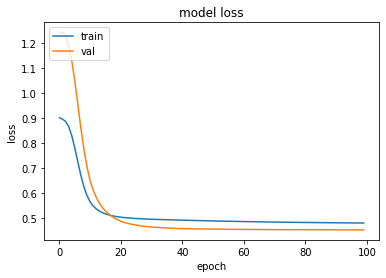

In [140]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [141]:
dataset_testX, dataset_testy = split_sequences(dataset_test, n_steps=NSTEPS)
yhat_test = model.predict(dataset_testX, verbose=0)

In [142]:
yhat_test.shape, dataset_testy.shape

((961, 1), (961,))

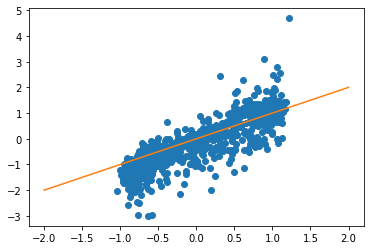

In [143]:
plt.plot(yhat_test.squeeze(), dataset_testy, 'o')
plt.plot([-2,2],[-2,2])

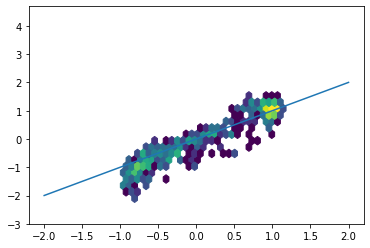

In [144]:
plt.hexbin(yhat_test.squeeze(), dataset_testy, mincnt=2, gridsize=30, bins='log')
plt.plot([-2,2],[-2,2])

#plt.plot([-2,2], [-2,2], 'r', lw=2)

In [147]:
diagnostic_stats(dataset_testy*y_test_std + y_test_mean, 
                 yhat_test.squeeze()*y_test_std + y_test_mean)

RMSE: 2.103, R^2: 0.770, MBE: -0.522, IOAD: 0.946


(2.103257097992616, 0.7700701982548716, -0.522244339180646, 0.9464053282225209)

#### Classical learning

In [67]:
def rmsle_randomsearchcv(model, params, X_train, y_train, n_folds, random_state=0):
    clf = RandomizedSearchCV(model, params, random_state=random_state, cv=n_folds, return_train_score=True, 
                         scoring="neg_mean_squared_error")
    search = clf.fit(X_train, y_train)
    rmse= np.sqrt(-search.best_score_)
    return rmse, search


In [81]:
# Hyperparameter Optz
params = dict(num_leaves = randint(2,10), 
              n_estimators = randint(500,2000),
              learning_rate = uniform(1e-3, 1),
              min_data_in_leaf = randint(2,10),
              objective=['regression'])

model_lgb = lgb.LGBMRegressor()
score_lgb, model_lgb = rmsle_randomsearchcv(model_lgb, params, dataset_train[:,:-1], 
                                            dataset_train[:,-1], 5)
print("\nLightGBM score: {:.4f} (+/-{:.4f})\n".format(score_lgb.mean(), score_lgb.std()))


LightGBM score: 0.7752 (+/-0.0000)



In [148]:
yhat_lgbm = model_lgb.predict(dataset_test[:,:-1])
diagnostic_stats(dataset_test[:,-1]*y_test_std + y_test_mean, 
                 yhat_lgbm*y_test_std + y_test_mean)

RMSE: 2.120, R^2: 0.746, MBE: -0.515, IOAD: 0.948


(2.119598996485539,
 0.7457571041854981,
 -0.5146981837801385,
 0.9479169953926919)

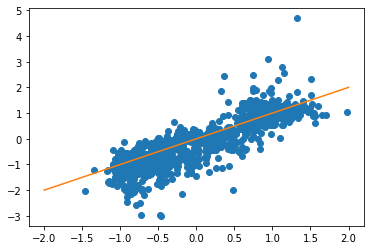

In [84]:
plt.plot(yhat_lgbm.squeeze(), dataset_test[:,-1], 'o')
plt.plot([-2,2],[-2,2])